# Results visualization

## Plots creation

The code to plot (`utils.plot_utils`) comes from [this repo](https://github.com/yui-mhcp/data_processing). The unnecessary modules (`audios / image / text`) have been removed to reduce the number of dependancies.

In [3]:
import os
import glob
import importlib
import collections
import numpy as np
import pandas as pd

from utils import plot_utils, load_json

models = {
    "Siamese"      : "audio_siamese_256_mel_lstm",
    "GE2E encoder" : "audio_encoder_256_mel_lstm",
    "Multi siamese" : "sv2tts_tacotron2_256",
    "Female-3000" : "sv2tts_siwis",
    "Multi GE2E (1)" : "sv2tts_tacotron2_256_v2",
    "Multi GE2E (2)" : "sv2tts_tacotron2_256_v2_2",
    "Female-250" : "paper_sv2tts-siwis-250",
    "Female-24"  : "paper_sv2tts-siwis-24-test2",
    "Male-100"   : "paper_sv2tts-kaggle-100",
    "Male-1000"  : "paper_sv2tts-kaggle-1000-test4"
}
model_alias = {v : k for k, v in models.items()}

voice_alias = {'kaggle' : 'Male', 'siwis' : 'Female'}

files = glob.glob(os.path.join('results', '*.json'))
files = sorted([f for f in files if not f.endswith('audio_0.json')])

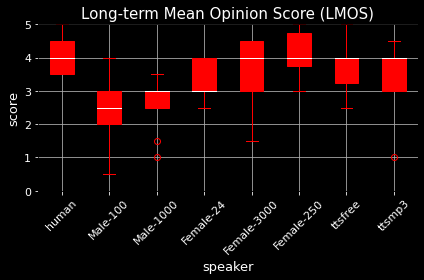

{'human': [5.0, 3.5, 4.0, 3.5, 3.5, 4.5, 4, 5.0, 3.5],
 'Male-100': [2.0, 0.5, 4.0, 2.5, 1.0, 3, 2.5, 2.5, 3.0],
 'Male-1000': [3.0, 1.0, 3.0, 2.5, 1.5, 3.5, 3, 2.5, 3.0],
 'Female-24': [3.0, 2.5, 4.0, 4.0, 3.0, 3, 2.5, 4.0, 3.5],
 'Female-3000': [4.0, 1.5, 4.0, 3.0, 2.5, 4.5, 3.5, 4.5, 4.5],
 'Female-250': [3.0, 5.0, 4.0, 5, 3.5, 4.5, 4.0],
 'ttsfree': [3.5, 4.0, 2.5, 5, 3, 4.0, 4.0],
 'ttsmp3': [1.0, 3.0, 3.0, 4, 4, 4.0, 4.5]}

In [4]:
importlib.reload(plot_utils)

lmos_mapping = {
    '0'    : 'human',
    '24'   : 'Female-24',
    '100'  : 'Male-100',
    '250'  : 'Female-250',
    '1000' : 'Male-1000',
    '9000' : 'Female-3000'
}
# plots for the paper
plot_config = {
    # default color kwargs (from `plot_utils.plot`)
    'color'       : 'gray',
    'facecolor'   : 'white',
    'fontcolor'   : 'black',
    # modified kwargs
    'mediancolor' : 'black',
    'with_grid'   : False
}

plot_config = {
    # default color kwargs (from `plot_utils.plot`)
    'color'       : 'red',
    'facecolor'   : 'black',
    'fontcolor'   : 'w',
    # modified kwargs
    'mediancolor' : 'white',
    'with_grid'   : True
}

def get_lmos_speaker(audio):
    suffix = audio.split('_')[-1].split('.')[0]
    
    return lmos_mapping.get(suffix, suffix)

def show_lmos():
    scores = {}
    for file in files:
        res = load_json(file)
        
        for audio, score in sorted(res.get('bmos', {}).get('score', {}).items()):
            scores.setdefault(get_lmos_speaker(audio), []).append(score)
    
    scores = {k : v for k, v in scores.items() if len(v) >= 5}
    
    plot_utils.plot(
        scores, plot_type = 'boxplot', title = 'Long-term Mean Opinion Score (LMOS)',
        xlabel = 'speaker', ylabel = 'score', xtick_rotation = 45, ylim = (0, 5),
        filename = 'plots/lmos.png', show = True, ** plot_config
    )
    
    return scores

lmos = show_lmos()
lmos

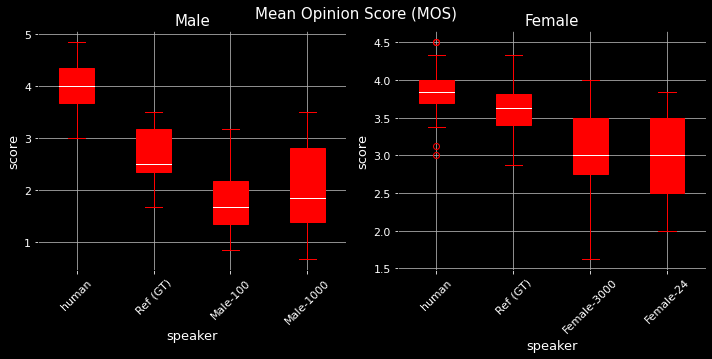

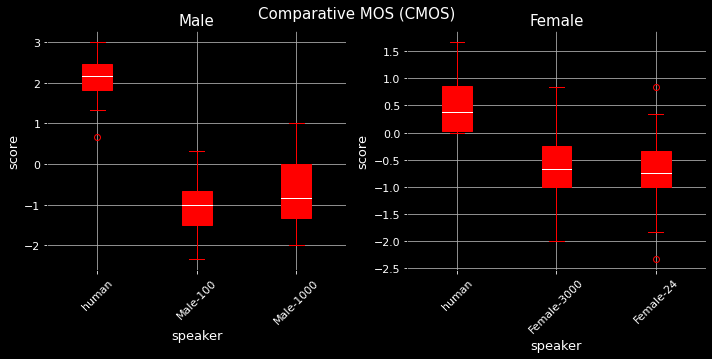

In [5]:
importlib.reload(plot_utils)

mos_mapping = {
    '0'    : 'human',
    '1'    : 'Ref (GT)',
    ('siwis', '2')  : 'Female-3000',
    ('siwis', '3')  : 'Female-24',
    ('kaggle', '2') : 'Male-100',
    ('kaggle', '3') : 'Male-1000'
}

def get_mos_speaker(voice, audio):
    suffix = audio.split('_')[-1].split('.')[0]
    
    if suffix in ('0', '1'):
        return mos_mapping.get(suffix, suffix)
    return mos_mapping.get((voice, suffix), suffix)

def show_mos():
    default_kwargs = {
        'plot_type' : 'boxplot', 'xlabel' : 'speaker', 'ylabel' : 'score', 'xtick_rotation' : 45, 'use_subplots' : True,
        ** plot_config
    }
    
    mos, cmos = {}, {}
    for file in files:
        res = load_json(file)
        
        for voice, infos in res.get('mos', {}).items():
            mos.setdefault(voice, {})
            cmos.setdefault(voice, {})
            for audio, score in infos.get('score', {}).items():
                mos[voice].setdefault(audio, []).append(score)
            
            for audio, score in infos.get('cmos', {}).items():
                cmos[voice].setdefault(audio, []).append(score)
    
    for scores in (mos, cmos):
        for voice, infos in scores.items():
            for audio in list(sorted(infos.keys())):
                scores[voice].setdefault(get_mos_speaker(voice, audio), []).append(float(np.mean(infos.pop(audio))))
    
    plot_utils.plot_multiple(
        ** {voice_alias.get(k, k) : {'x' : v} for k, v in mos.items()}, title = 'Mean Opinion Score (MOS)', ** default_kwargs,
        filename = 'plots/mos.png', show = True
    )
    
    plot_utils.plot_multiple(
        ** {voice_alias.get(k, k) : {'x' : v} for k, v in cmos.items()}, title = 'Comparative MOS (CMOS)', ** default_kwargs,
        filename = 'plots/cmos.png', show = True
    )
    
    return mos, cmos

mos, cmos = show_mos()
#{'mos' : mos, 'cmos' : cmos}

## Creates the pd.DataFrame + latex tabular

In [6]:
def format_metric(v):
    if not v: return '0'
    return '{:.2f} (+/- {:.2f})'.format(np.mean(v), np.std(v))

mos_alias = {
    ('siwis', 'human') : 'Female',
    ('siwis', 'Ref (GT)') : 'Female (GT)',
    ('kaggle', 'human') : 'Male',
    ('kaggle', 'Ref (GT)') : 'Male (GT)',
}

mos_models = []
for voice, model_names in mos.items():
    mos_models.extend([(voice, m) for m in model_names])

mos_df = pd.DataFrame({
    mos_alias.get((voice, model), model) : {
        'MOS' : format_metric(mos[voice][model]), 'CMOS' : format_metric(cmos[voice].get(model, []))
    } for (voice, model) in mos_models
}).T
print(mos_df)
print(mos_df.style.to_latex())

                         MOS              CMOS
Male         3.96 (+/- 0.46)   2.13 (+/- 0.46)
Male (GT)    2.62 (+/- 0.49)                 0
Male-100     1.83 (+/- 0.64)  -1.03 (+/- 0.61)
Male-1000    2.04 (+/- 0.76)  -0.65 (+/- 0.82)
Female       3.84 (+/- 0.31)   0.47 (+/- 0.44)
Female (GT)  3.59 (+/- 0.26)                 0
Female-3000  3.07 (+/- 0.48)  -0.64 (+/- 0.56)
Female-24    2.97 (+/- 0.53)  -0.67 (+/- 0.61)
\begin{tabular}{lll}
 & MOS & CMOS \\
Male & 3.96 (+/- 0.46) & 2.13 (+/- 0.46) \\
Male (GT) & 2.62 (+/- 0.49) & 0 \\
Male-100 & 1.83 (+/- 0.64) & -1.03 (+/- 0.61) \\
Male-1000 & 2.04 (+/- 0.76) & -0.65 (+/- 0.82) \\
Female & 3.84 (+/- 0.31) & 0.47 (+/- 0.44) \\
Female (GT) & 3.59 (+/- 0.26) & 0 \\
Female-3000 & 3.07 (+/- 0.48) & -0.64 (+/- 0.56) \\
Female-24 & 2.97 (+/- 0.53) & -0.67 (+/- 0.61) \\
\end{tabular}



In [23]:
lmos_df = pd.DataFrame({k : {'LMOS' : '{:.2f} (+/- {:.2f})'.format(np.mean(v), np.std(v))} for k, v in lmos.items()}).T
lmos_df = lmos_df.sort_values('LMOS', ascending = False)
print(lmos_df)
# Removes the `.T` for vertical tabular
print(lmos_df.T.style.to_latex())

                        LMOS
Female-250   4.14 (+/- 0.69)
human        4.06 (+/- 0.60)
ttsfree      3.71 (+/- 0.75)
Female-3000  3.56 (+/- 0.98)
ttsmp3       3.36 (+/- 1.09)
Female-24    3.28 (+/- 0.58)
Male-1000    2.56 (+/- 0.76)
Male-100     2.33 (+/- 1.00)
\begin{tabular}{lllllllll}
 & Female-250 & human & ttsfree & Female-3000 & ttsmp3 & Female-24 & Male-1000 & Male-100 \\
LMOS & 4.14 (+/- 0.69) & 4.06 (+/- 0.60) & 3.71 (+/- 0.75) & 3.56 (+/- 0.98) & 3.36 (+/- 1.09) & 3.28 (+/- 0.58) & 2.56 (+/- 0.76) & 2.33 (+/- 1.00) \\
\end{tabular}

